In [1]:
import pandas as pd
import numpy as np
import time
import multiprocessing as mp
from dask.dataframe import from_pandas
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 100)

# 1. BeforeModel

## 1.1 Pandas 

In [2]:
# read data
data = pd.read_csv('onlinefraud.csv')
data = data.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)

# feature engineering
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = "ignore",sparse=False)
type_enc = enc.fit_transform(data['type'].values.reshape(-1, 1))
data = pd.concat([data,pd.DataFrame(type_enc)],axis=1)
data.rename(columns={0:'type_CASH_IN',1:'type_CASH_OUT',2:'type_DEBIT',3:'type_PAYMENT',4:'type_TRANSFER'},inplace=True)
data = data.drop('type',axis=1)
data['orig_balance_diff'] = data.oldbalanceOrg - data.newbalanceOrig
data['dest_balance_diff'] = data.oldbalanceDest - data.newbalanceDest
data = data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
data = data.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

# Handling unbalanced data
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsFraud_over = IsFraud.sample(IsNotFraud_count,replace=True)
over_balanced_data = pd.concat([IsNotFraud,IsFraud_over], axis=0)
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data = pd.concat([IsNotFraud_under,IsFraud], axis=0)

## 1.2 Dask

In [3]:
# read data
data_dd = pd.read_csv('onlinefraud.csv')
data_dd = data_dd.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)
data_dd = from_pandas(data_dd, npartitions = 16)

# feature engineering
from dask_ml.preprocessing import DummyEncoder
encoder = DummyEncoder()  
data_dd = data_dd.categorize(['type'])
data_dd = encoder.fit_transform(data_dd)
data_dd['orig_balance_diff'] = data_dd.oldbalanceOrg - data_dd.newbalanceOrig
data_dd['dest_balance_diff'] = data_dd.oldbalanceDest - data_dd.newbalanceDest
data_dd = data_dd.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
data_dd = data_dd.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

# Handling unbalanced data
IsNotFraud_count,IsFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]
IsFraud_over = IsFraud.sample(frac = 773.7,replace=True)
over_balanced_data_dd = dd.concat([IsNotFraud,IsFraud_over], axis=0)
IsFraud_count, IsNotFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data_dd = dd.concat([IsNotFraud_under,IsFraud], axis=0)

# 2. Results Evaluation

## 2.1 Pandas 

### 2.1.1 Model evaluation metrics

In [4]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 CPU(pandas): 

accuracy  0.9783802333562114
precision 0.9720442632498544
recall    0.9910926365795725
f1        0.9814760364598647


In [5]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 CPU(pandas): 

accuracy  0.9790665751544269
precision 0.9726266744321491
recall    0.9916864608076009
f1        0.9820640987944722


In [6]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.8,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 CPU(pandas): 

accuracy  0.9783802333562114
precision 0.9742539496781744
recall    0.9887173396674585
f1        0.9814323607427056


In [7]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.8,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 8 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 8 CPU(pandas): 

accuracy  0.9790665751544269
precision 0.9737302977232924
recall    0.9904988123515439
f1        0.9820429790992052


In [8]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 GPU(pandas): 

accuracy  0.9790665751544269
precision 0.9726266744321491
recall    0.9916864608076009
f1        0.9820640987944722


In [9]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 GPU(pandas): 

accuracy  0.9790665751544269
precision 0.9726266744321491
recall    0.9916864608076009
f1        0.9820640987944722


In [10]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 GPU(pandas): 

accuracy  0.9790665751544269
precision 0.9726266744321491
recall    0.9916864608076009
f1        0.9820640987944722


### 2.1.2 Speedup and efficiency

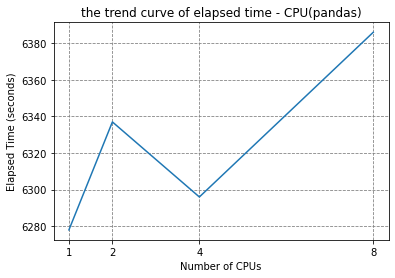

In [11]:
# Elapsed time - CPU(pandas)
time1 = 6278
time2 = 6337
time4 = 6296
time8 = 6386
plt.plot([1,2,4,8],[time1,time2,time4,time8])
plt.title("the trend curve of elapsed time - CPU(pandas)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

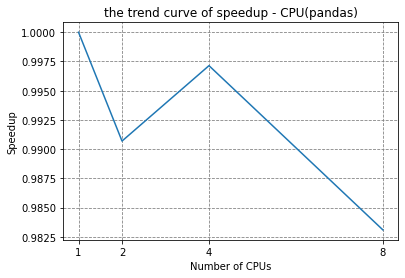

In [12]:
# Speedup - CPU(pandas)
speedup1 = time1/time1
speedup2 = time1/time2
speedup4 = time1/time4
speedup8 = time1/time8
plt.plot([1,2,4,8],[speedup1,speedup2,speedup4,speedup8])
plt.title("the trend curve of speedup - CPU(pandas)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

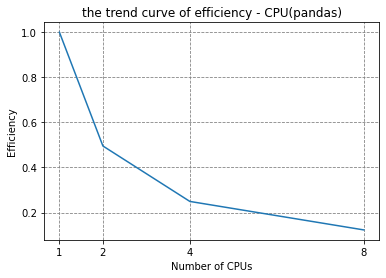

In [13]:
# Efficiency - CPU(pandas)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency4 = speedup4/4
efficiency8 = speedup8/8
plt.plot([1,2,4,8],[efficiency1,efficiency2,efficiency4,efficiency8])
plt.title("the trend curve of efficiency - CPU(pandas)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

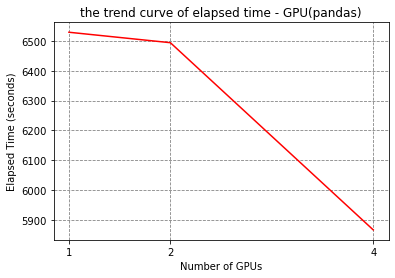

In [14]:
# Elapsed time - GPU(pandas)
time1 = 6529
time2 = 6494
time4 = 5867
plt.plot([1,2,4],[time1,time2,time4],color = 'red')
plt.title("the trend curve of elapsed time - GPU(pandas)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

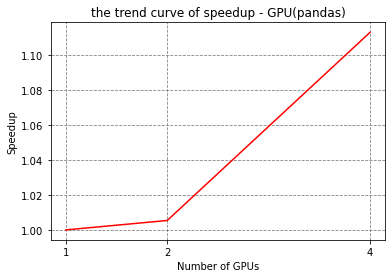

In [15]:
# Speedup - GPU(pandas)
speedup1 = time1/time1
speedup2 = time1/time2
speedup4 = time1/time4
plt.plot([1,2,4],[speedup1,speedup2,speedup4],color = 'red')
plt.title("the trend curve of speedup - GPU(pandas)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

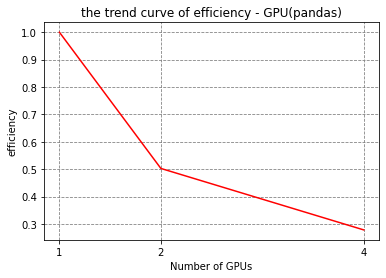

In [16]:
# Efficiency - GPU(pandas)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency4 = speedup4/4
plt.plot([1,2,4],[efficiency1,efficiency2,efficiency4],color = 'red')
plt.title("the trend curve of efficiency - GPU(pandas)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

## 2.2 Dask

### 2.2.1 Model evaluation metrics

In [17]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=200,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 CPU(Dask): 

accuracy  0.9757679180887372
precision 0.9674556213017751
recall    0.9903089036947305
f1        0.9787488775815625


In [18]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.6,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 CPU(Dask): 

accuracy  0.9689419795221843
precision 0.9710144927536232
recall    0.9739551786795881
f1        0.9724826126398549


In [19]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.6,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 CPU(Dask): 

accuracy  0.9696245733788396
precision 0.971049457177322
recall    0.9751665657177468
f1        0.9731036566938652


In [20]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.8,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 8 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 8 CPU(Dask): 

accuracy  0.9689419795221843
precision 0.9704463208685162
recall    0.9745608721986675
f1        0.9724992444847386


In [21]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.8,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 GPU(Dask): 

accuracy  0.9692832764505119
precision 0.9710319855159928
recall    0.9745608721986675
f1        0.9727932285368803


In [22]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 GPU(Dask): 

accuracy  0.9706484641638226
precision 0.9688436189334931
recall    0.9794064203513022
f1        0.9740963855421687


In [23]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=200,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 GPU(Dask): 

accuracy  0.9757679180887372
precision 0.9674556213017751
recall    0.9903089036947305
f1        0.9787488775815625


### 2.2.2 Speedup and efficiency

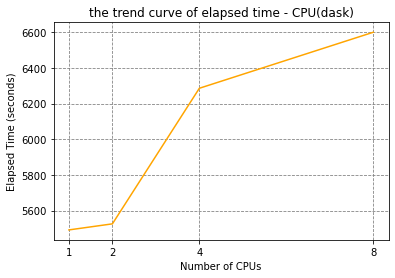

In [24]:
# Elapsed time - CPU(dask)
time1 = 5492
time2 = 5526
time4 = 6286
time8 = 6600
plt.plot([1,2,4,8],[time1,time2,time4,time8],color = 'orange')
plt.title("the trend curve of elapsed time - CPU(dask)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

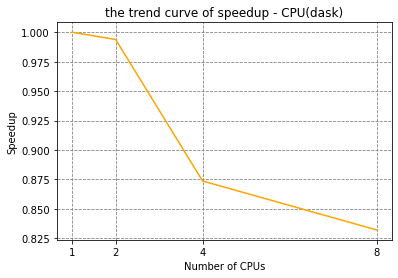

In [25]:
# Speedup - CPU(dask)
speedup1 = time1/time1
speedup2 = time1/time2
speedup4 = time1/time4
speedup8 = time1/time8
plt.plot([1,2,4,8],[speedup1,speedup2,speedup4,speedup8],color = 'orange')
plt.title("the trend curve of speedup - CPU(dask)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

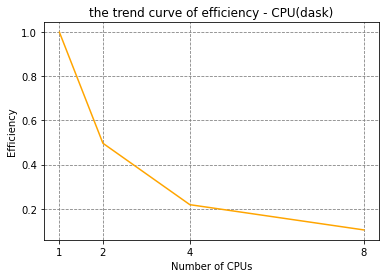

In [26]:
# Efficiency - CPU(dask)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency4 = speedup4/4
efficiency8 = speedup8/8
plt.plot([1,2,4,8],[efficiency1,efficiency2,efficiency4,efficiency8],color = 'orange')
plt.title("the trend curve of efficiency - CPU(dask)")
plt.xticks([1, 2, 4, 8])
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

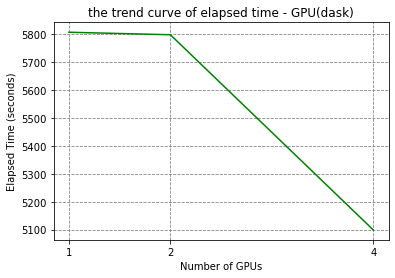

In [27]:
# Elapsed time - GPU(dask)
time1 = 5808
time2 = 5799
time4 = 5099
plt.plot([1,2,4],[time1,time2,time4],color = 'green')
plt.title("the trend curve of elapsed time - GPU(dask)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

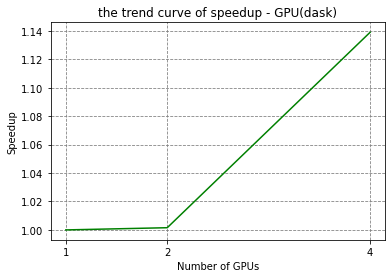

In [28]:
# Speedup - GPU(dask)
speedup1 = time1/time1
speedup2 = time1/time2
speedup4 = time1/time4
plt.plot([1,2,4],[speedup1,speedup2,speedup4],color = 'green')
plt.title("the trend curve of speedup - GPU(dask)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

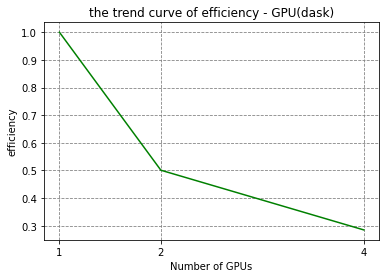

In [29]:
# Efficiency - GPU(dask)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency4 = speedup4/4
plt.plot([1,2,4],[efficiency1,efficiency2,efficiency4],color = 'green')
plt.title("the trend curve of efficiency - GPU(dask)")
plt.xticks([1, 2, 4])
plt.xlabel('Number of GPUs')
plt.ylabel('efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')